In [2]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from itertools import product

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from scipy.stats import mode

I pulled and cleaned a comprehensive dataset of colleges from this governmental database:
    
https://collegescorecard.ed.gov/data/

Let's read this dataset in:

In [3]:
df = pd.read_csv('data/schools.csv', index_col = 0)
print(df.shape)
df.head()

(6740, 46)


,name,ownership,ope6_id,state,size,accreditor,retention,branches,online_only,religious_affil,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,Alaska Bible College,2,8843,AK,27,Association for Bibical Higher Educaiton,0.333300,1,0,88.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,Alaska Christian College,2,41386,AK,68,Association for Bibical Higher Educaiton,0.473700,1,0,37.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,Ilisagvik College,1,34613,AK,109,Northwest Commission on Colleges and Universities,0.809500,1,0,-2.0,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,Charter College-Anchorage,3,25769,AK,3256,Accrediting Council for Independent Colleges a...,0.703723,1,0,-2.0,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,Alaska Career College,3,25410,AK,479,Accrediting Commission of Career Schools and C...,0.794100,1,0,-2.0,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


We are going to use classification algorithms to try to predict for-profit or non-profit status. 

Some of the categories aren't applicable to what we want to do so let's consider the following columns only:


In [4]:
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]
X.head()

,size,retention,branches,online_only,under_investigation,most_common_degree,highest_degree,faculty_salary,instructional_expenditure_per_fte,tuition_revenue_per_fte,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,27,0.333300,1,0,0,3,3,2201,9585,8132,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,68,0.473700,1,0,0,1,2,5554,18174,12989,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,109,0.809500,1,0,0,1,2,6054,38265,3587,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,3256,0.703723,1,0,0,1,3,4004,2617,8755,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,479,0.794100,1,0,0,1,2,3861,4178,11905,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


Let's first use a method called [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) to see which features have the most statistically significant relationships with profit status. The **lower** the p value, the **more** statistically significant:

In [5]:
y = X.pop('for_profit')

X_new = SelectKBest(chi2, k=2).fit(X, y)

features = []
for i, column in enumerate(X.columns):
    features.append((X_new.pvalues_[i], column))
features.sort()
print('chi2-value', 'feature')
features

chi2-value feature


[(0.0, 'avg_family_income'),
 (0.0, 'branches'),
 (0.0, 'faculty_salary'),
 (0.0, 'instructional_expenditure_per_fte'),
 (0.0, 'loan_principal'),
 (0.0, 'pell_grant_debt'),
 (0.0, 'size'),
 (0.0, 'tuition_revenue_per_fte'),
 (5.339096890496358e-283, 'highest_degree'),
 (2.3550018048916394e-222, 'most_common_degree'),
 (5.4025502611485345e-149, 'fac_salary_listed_y_n'),
 (8.240679129762035e-148, 'relig_y_n'),
 (5.293172158552389e-143, 'age_entry'),
 (1.4125160311604572e-48, 'percent_dependent'),
 (1.429381130658807e-24, '5_year_declining_balance'),
 (1.3527931483014932e-21, 'federal_loan_rate'),
 (6.095800240149601e-17, 'percent_black'),
 (3.249757484508949e-15, 'fafsa_sent'),
 (2.3099399670292976e-10, '7_yr_repayment_completion'),
 (5.332261659651546e-09, 'first_generation'),
 (1.4079344574521532e-08, 'part_time_share'),
 (1.51637032044754e-08, 'dep_low_income'),
 (5.389960032435694e-08, 'percent_pell_grant'),
 (2.9423628117769607e-06, 'students_with_any_loans'),
 (9.035892891499908e-0

1.Based on the info above, what was intuitive? What was surprising? How big (or small) of an effect does accredition have on for-profit status? What might be some guesses as to why this is the case?

In [6]:
#insert 1
#Family income and faculty salary would seem to be most correlated with whether or not a school is for profit because more money flowing into the school means it has more money to spend, particularly on faculty salaries.
#I did not think that size would affect whether or not a school is for profit.
#Accredition does not seem to have any sort of correlation wiht for profit status, which may be because it is given to schools based on aspects that do not affect profit.

2.Do a test/train split and give the testing accuracy error for logistic regression.

In [7]:
#insert 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model.fit(X_train, y_train)
 
y_proba_LR = model.predict_proba(X_test)[:, 1]

print('accuracy:', model.score(X_test,y_test))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_LR))

accuracy: 0.9008902077151335
ROC-AUC: 0.9468546264600141


3.Find the optimal number of nearest neighbors for KNN using grid search and then give the test accuracy. 

In [8]:
#insert 3
param_grid = {'n_neighbors': range(1, 20)}

model = GridSearchCV(KNeighborsClassifier(), 
                    param_grid, 
                    cv=3, 
                    scoring='accuracy')

model = model.fit(X_train, y_train)

y_proba_KNN = model.predict_proba(X_test)[:, 1]

print(model.best_params_)

print('accuracy:', model.score(X_test,y_test))

{'n_neighbors': 3}
accuracy: 0.9002967359050446


4.Run a classification report and describe in detail what the terms mean in the context of your model.

In [9]:
#insert 4
model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       953
           1       0.87      0.91      0.89       732

    accuracy                           0.90      1685
   macro avg       0.90      0.90      0.90      1685
weighted avg       0.90      0.90      0.90      1685



5.Print a confusion matrix and describe what it means in your context.

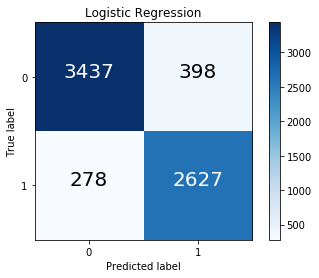

In [10]:
#insert 5
def plot_confusion_matrix(cm, classes=[0, 1], title='Logistic Regression',
                          normalize=False,
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center", size=20,
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
plot_confusion_matrix(confusion_matrix(y, model.predict(X)))

#3437 colleges were accurately predicted as being not for profit
#2627 colleges were accurately predicted as being for profit
#398 not for profit colleges were mis-classified as being for profit
#278 for profit colleges were mis-classified as being not for profit

6.Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, and KNN classifiers.

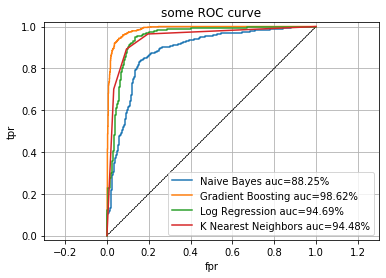

In [11]:
#insert 6
def plot_roc(ytrue, yproba, model, title='some ROC curve'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)

model = naive_bayes.GaussianNB()
model.fit(X_train, y_train)
   
y_proba_NB = model.predict_proba(X_test)[:, 1]

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

y_proba_GB = model.predict_proba(X_test)[:, 1]

plot_roc(y_test, y_proba_NB, "Naive Bayes")
plot_roc(y_test, y_proba_GB, "Gradient Boosting")
plot_roc(y_test, y_proba_LR, "Log Regression")
plot_roc(y_test, y_proba_KNN, "K Nearest Neighbors")

7.Using the logarithmic regression model, plot a decision boundary between instructional_expenditure_per_fte and 5_year_declining_balance. Does it appear that for-profit status has a clear boundary based on these predictors?

(-2.941558886777559, 3.1784411132224464)

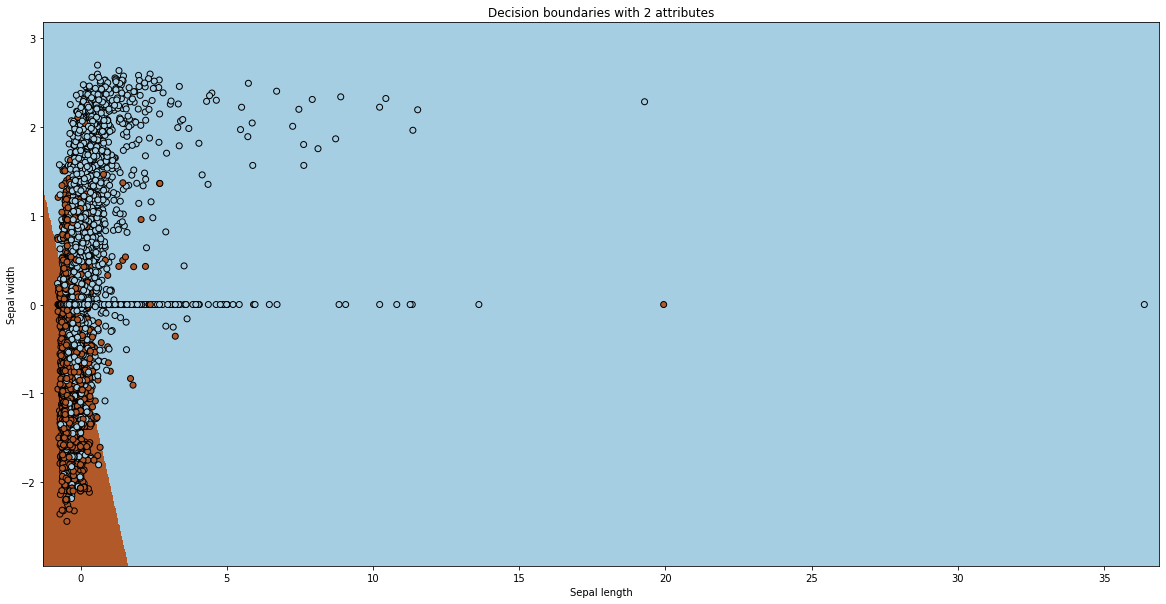

In [12]:
#insert 7
X = df[['instructional_expenditure_per_fte', '5_year_declining_balance']]
X_scaler = StandardScaler()
X = X_scaler.fit_transform(X)
X = pd.DataFrame(X)

Q = X.values
Q = X.values
h = .02  # meshsize
x_min, x_max = Q[:, 0].min() - .5, Q[:, 0].max() + .5 
y_min, y_max = Q[:, 1].min() - .5, Q[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model.fit(X.iloc[:,:2], y)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # ravel() flattens the data

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(20, 10))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(Q[:, 0], Q[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision boundaries with 2 attributes')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

8.We have not covered random forests but they are a very popular type of classifier. It is very good practice in reading the docs to get a new classifier working. Read [this](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and then apply the RandomForestClassifier().

In [13]:
#insert 8
from sklearn.ensemble import RandomForestClassifier
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n']]
X = X_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_proba_RFC = clf.predict_proba(X_test)[:, 1]
print(clf.score(X_test,y_test))
print(classification_report(y_test, clf.predict(X_test)))

0.8646884272997033
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       953
           1       0.81      0.91      0.85       732

    accuracy                           0.86      1685
   macro avg       0.86      0.87      0.86      1685
weighted avg       0.87      0.86      0.87      1685



9.Support vector machines are another type of classifier. Read the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and then try implementing that one.

In [14]:
#insert 9
from sklearn.svm import SVC
clf = SVC(gamma = 'scale', probability = True)
clf.fit(X_train, y_train)
y_proba_SVM = clf.predict_proba(X_test)[:, 1]
print(clf.score(X_test,y_test))
print(classification_report(y_test, clf.predict(X_test)))

0.9335311572700297
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       953
           1       0.91      0.94      0.93       732

    accuracy                           0.93      1685
   macro avg       0.93      0.93      0.93      1685
weighted avg       0.93      0.93      0.93      1685



10. Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, KNN classifiers, random forest, and SVM classifiers.

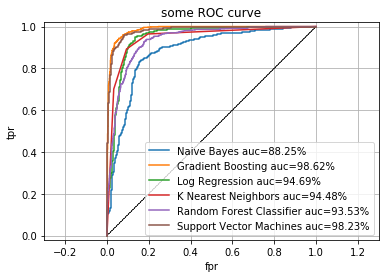

In [15]:
#insert 10
plot_roc(y_test, y_proba_NB, "Naive Bayes")
plot_roc(y_test, y_proba_GB, "Gradient Boosting")
plot_roc(y_test, y_proba_LR, "Log Regression")
plot_roc(y_test, y_proba_KNN, "K Nearest Neighbors")
plot_roc(y_test, y_proba_RFC, "Random Forest Classifier")
plot_roc(y_test, y_proba_SVM, "Support Vector Machines")

11.Take in a new school's data and predict the school's profit status using one of your previous classifier methods.

In [22]:
#insert 11
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
model.predict([X[200]])

array([1])

12.What are the worst schools? Some of them are chains of schools so don't necessarily consider singular names but generalize to chains. Give a lot of justification for your analysis as everyone might have a different answer here. Insert these responses into your blog.

In [17]:
# insert 12
#categories to consider: retention, under_investigation, most_common_degree, loan_principle, students_with_any_loans, accred_y_n.
bad_schools = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n']]
bad_schools = bad_schools[['retention','most_common_degree','students_with_any_loans','accred_y_n']]
bad_schools = bad_schools[bad_schools['accred_y_n'] == 0]
bad_schools['rating'] = (1-bad_schools['retention']) + bad_schools['students_with_any_loans'] + (1-bad_schools['most_common_degree']*0.25)
print(bad_schools[bad_schools['rating'] >= 2])
list_of_schools = [400,1265,1434,2211,3043,5754,5912,5919,6067,6616,6621,6771]
for i in range(len(list_of_schools)):
    print(df.loc[list_of_schools[i]][0])

      retention  most_common_degree  students_with_any_loans  accred_y_n  \
400    0.454500                   1                 0.779431           0   
1265   0.703723                   0                 0.779431           0   
1434   0.613400                   1                 0.891143           0   
2211   0.488000                   1                 0.829642           0   
3043   0.703723                   0                 0.779431           0   
5754   0.200000                   1                 0.885714           0   
5912   0.615400                   1                 0.943609           0   
5919   0.625000                   1                 0.950178           0   
6067   0.444400                   1                 0.779431           0   
6616   0.577300                   1                 0.829309           0   
6621   0.543500                   1                 0.840321           0   
6771   0.500000                   1                 0.867580           0   

        rat

13.If you were a governmental organization overseeing accreditation, what factors would be most important to you in making sure that the college was non-predatory? Give a lot of detail here as well in your blog.

The biggest thing to consider would be if the college was for profit or not. A not for profit college is unlikely to be predatory because they have nothing to gain from students attending. Then, once the college is seen as for profit, the next most important aspect is to check how much money the college actually makes, and how much debt the students are placed in. If the faculty salary is extremely high but the students have exceedingly heavy loans after they graduate, which they struggle to pay off, that would indicate predatory practices. These students would likely come from families who could afford to pay some of a high tuition, but had to take out huge loans on the rest of the tuition. Also, if the faculty salary listed is significantly lower than the actual faculty salary, then it is likely that the college does not want people finding out how much money their faculty make, which indicates that they are attempting to steal from students. Of course, if the students are getting high degrees, then the college is probably giving them a good education, but if students are only graduating with associates degrees or lower, then the college is likely not focusing on the students' education and instead wants to take their money without giving them anything in return. A dead giveaway would be if the college is under investigation.

14.Read several articles on college predatory practices and cite and incorporate them into your blog discussion. Remember to link to them clearly by using the 
```[here](http://....)``` syntax.